<a href="https://colab.research.google.com/github/akhil1729/Python-Projects/blob/main/Project_2_601.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Landslide Export dataset recorded by NASA

Project 2 dataset link : https://catalog.data.gov/dataset/global-landslide-catalog-export/resource/e9aad2b3-4ac1-443f-a6a8-e2e56a18babc

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import geopandas as gpd
#!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#!pip install rasterio
import rasterio
from rasterio.enums import Resampling
from rasterio.plot import show
import numpy as np

In [148]:
df=pd.read_csv('Global_Landslide_Catalog_Export.csv')
#print(df.head())
df.head()

,source_name,source_link,event_id,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
0,AGU,https://blogs.agu.org/landslideblog/2008/10/14...,684,08/01/2008 12:00:00 AM,NaN,"Sigou Village, Loufan County, Shanxi Province","occurred early in morning, 11 villagers buried...","Sigou Village, Loufan County, Shanxi Province",unknown,landslide,...,CN,Shaanxi,0.0,Jingyang,41.02145,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,107.4500,32.5625
1,Oregonian,http://www.oregonlive.com/news/index.ssf/2009/...,956,01/02/2009 02:00:00 AM,NaN,"Lake Oswego, Oregon",Hours of heavy rain are to blame for an overni...,"Lake Oswego, Oregon",5km,mudslide,...,US,Oregon,36619.0,Lake Oswego,0.60342,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-122.6630,45.4200
2,CBS News,https://www.cbsnews.com/news/dozens-missing-af...,973,01/19/2007 12:00:00 AM,NaN,"San Ramon district, 195 miles northeast of the...",(CBS/AP) At least 10 people died and as many a...,"San Ramon district, 195 miles northeast of the...",10km,landslide,...,PE,Junín,14708.0,San Ramón,0.85548,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-75.3587,-11.1295
3,Reuters,https://in.reuters.com/article/idINIndia-41450...,1067,07/31/2009 12:00:00 AM,NaN,Dailekh district,"One person was killed in Dailekh district, pol...",Dailekh district,unknown,landslide,...,NP,Mid Western,20908.0,Dailekh,0.75395,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,81.7080,28.8378
4,The Freeman,http://www.philstar.com/cebu-news/621414/lands...,2603,10/16/2010 12:00:00 PM,NaN,sitio Bakilid in barangay Lahug,Another landslide in sitio Bakilid in barangay...,sitio Bakilid in barangay Lahug,5km,landslide,...,PH,Central Visayas,798634.0,Cebu City,2.02204,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,123.8978,10.3336


As we have event id with unique values as one of the columns in the dataset, we can use that attribute as primary key for further operations. lets move that column to the first place.

In [149]:
columns = df.columns.tolist()
columns.insert(0, columns.pop(2))
df=df[columns]
df

,event_id,source_name,source_link,event_date,event_time,event_title,event_description,location_description,location_accuracy,landslide_category,...,country_code,admin_division_name,admin_division_population,gazeteer_closest_point,gazeteer_distance,submitted_date,created_date,last_edited_date,longitude,latitude
0,684,AGU,https://blogs.agu.org/landslideblog/2008/10/14...,08/01/2008 12:00:00 AM,NaN,"Sigou Village, Loufan County, Shanxi Province","occurred early in morning, 11 villagers buried...","Sigou Village, Loufan County, Shanxi Province",unknown,landslide,...,CN,Shaanxi,0.0,Jingyang,41.02145,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,107.450000,32.562500
1,956,Oregonian,http://www.oregonlive.com/news/index.ssf/2009/...,01/02/2009 02:00:00 AM,NaN,"Lake Oswego, Oregon",Hours of heavy rain are to blame for an overni...,"Lake Oswego, Oregon",5km,mudslide,...,US,Oregon,36619.0,Lake Oswego,0.60342,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-122.663000,45.420000
2,973,CBS News,https://www.cbsnews.com/news/dozens-missing-af...,01/19/2007 12:00:00 AM,NaN,"San Ramon district, 195 miles northeast of the...",(CBS/AP) At least 10 people died and as many a...,"San Ramon district, 195 miles northeast of the...",10km,landslide,...,PE,Junín,14708.0,San Ramón,0.85548,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,-75.358700,-11.129500
3,1067,Reuters,https://in.reuters.com/article/idINIndia-41450...,07/31/2009 12:00:00 AM,NaN,Dailekh district,"One person was killed in Dailekh district, pol...",Dailekh district,unknown,landslide,...,NP,Mid Western,20908.0,Dailekh,0.75395,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,81.708000,28.837800
4,2603,The Freeman,http://www.philstar.com/cebu-news/621414/lands...,10/16/2010 12:00:00 PM,NaN,sitio Bakilid in barangay Lahug,Another landslide in sitio Bakilid in barangay...,sitio Bakilid in barangay Lahug,5km,landslide,...,PH,Central Visayas,798634.0,Cebu City,2.02204,04/01/2014 12:00:00 AM,11/20/2017 03:17:00 PM,02/15/2018 03:51:00 PM,123.897800,10.333600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11028,11109,The Jakarta Post,http://www.thejakartapost.com/news/2017/04/02/...,04/01/2017 01:34:00 PM,NaN,Major landslide in Banaran,Landslide exacerbated by deforestation and bad...,"Banaran, Ponorogo, Jawa Timur, Indonesia",5km,landslide,...,NaN,NaN,NaN,NaN,NaN,07/28/2017 01:34:00 PM,12/19/2017 09:42:00 PM,02/15/2018 03:51:00 PM,111.679944,-7.853409
11029,10845,Greater Kashmir,http://www.greaterkashmir.com/news/jammu/lands...,03/25/2017 05:32:00 PM,NaN,Barnari Sigdi Landslide,Two teenage girls died after they were buried ...,"Barnari Sigdi area, Tehsil Mughalmaidan, Kisht...",5km,landslide,...,NaN,NaN,NaN,NaN,NaN,09/21/2017 05:32:00 PM,12/05/2017 06:45:00 PM,02/15/2018 03:51:00 PM,75.680611,33.403080
11030,10973,NBC Daily,http://www.nbcdaily.com/separate-landslides-ki...,12/15/2016 05:00:00 AM,NaN,Landslide at Pub Sarania Hill,An octogenarian was killed when a sudden lands...,"Pub Sarania Hill, Guwahati, Assam, India",1km,landslide,...,NaN,NaN,NaN,NaN,NaN,07/26/2017 01:22:00 PM,12/08/2017 08:37:00 PM,02/15/2018 03:51:00 PM,91.772042,26.181606
11031,10901,AGU Landslide Blog,http://blogs.agu.org/landslideblog/2017/05/02/...,04/29/2017 07:03:00 PM,NaN,Mayor landslide at Ayu village,Landslide triggered by heavy rainfall buried 1...,"Ayu, Ozgon, Osh, Kyrgyzstan",1km,translational_slide,...,NaN,NaN,NaN,NaN,NaN,07/14/2017 07:03:00 PM,12/07/2017 09:19:00 PM,02/15/2018 03:51:00 PM,73.472379,40.886395


In [150]:
df.dtypes

event_id                       int64
source_name                   object
source_link                   object
event_date                    object
event_time                   float64
event_title                   object
event_description             object
location_description          object
location_accuracy             object
landslide_category            object
landslide_trigger             object
landslide_size                object
landslide_setting             object
fatality_count               float64
injury_count                 float64
storm_name                    object
photo_link                    object
notes                         object
event_import_source           object
event_import_id              float64
country_name                  object
country_code                  object
admin_division_name           object
admin_division_population    float64
gazeteer_closest_point        object
gazeteer_distance            float64
submitted_date                object
c

In [151]:
df.describe()

,event_id,event_time,fatality_count,injury_count,event_import_id,admin_division_population,gazeteer_distance,longitude,latitude
count,11033.000000,0.0,9648.000000,5359.000000,9471.000000,9.471000e+03,9471.000000,11033.000000,11033.000000
mean,5598.953141,NaN,3.219424,0.751819,4798.563070,1.577600e+05,11.873689,2.520441,25.881887
std,3249.228647,NaN,59.886178,8.458955,2789.125559,8.297345e+05,15.598228,100.908393,20.415054
min,1.000000,NaN,0.000000,0.000000,-111.167300,0.000000e+00,0.000030,-179.980766,-46.774800
25%,2785.000000,NaN,0.000000,0.000000,2386.500000,1.963000e+03,2.363845,-107.871700,13.917600
50%,5563.000000,NaN,0.000000,0.000000,4773.000000,7.365000e+03,6.254870,19.694600,30.534500
75%,8435.000000,NaN,1.000000,0.000000,7189.500000,3.402100e+04,15.815610,93.948000,40.866259
max,11221.000000,NaN,5000.000000,374.000000,9669.000000,1.269184e+07,215.448880,179.991364,72.627500


In [152]:
#this non zero values tell the count of empty cells in the given data.
print(df.isnull().sum())
# Get a concise summary of the dataframe
print(df.info())

event_id                         0
source_name                      0
source_link                    846
event_date                       0
event_time                   11033
event_title                      0
event_description              862
location_description           102
location_accuracy                2
landslide_category               1
landslide_trigger               23
landslide_size                   9
landslide_setting               69
fatality_count                1385
injury_count                  5674
storm_name                   10456
photo_link                    9537
notes                        10716
event_import_source           1563
event_import_id               1562
country_name                  1562
country_code                  1564
admin_division_name           1637
admin_division_population     1562
gazeteer_closest_point        1563
gazeteer_distance             1562
submitted_date                  10
created_date                     1
last_edited_date    

In [153]:
rows_with_empty_values = df[df.isnull().any(axis=1)]
print(rows_with_empty_values)
#this line helps us to show the rows having the null values in their records

       event_id         source_name  \
0           684                 AGU   
1           956           Oregonian   
2           973            CBS News   
3          1067             Reuters   
4          2603         The Freeman   
...         ...                 ...   
11028     11109    The Jakarta Post   
11029     10845     Greater Kashmir   
11030     10973           NBC Daily   
11031     10901  AGU Landslide Blog   
11032     10949  The Times of India   

                                             source_link  \
0      https://blogs.agu.org/landslideblog/2008/10/14...   
1      http://www.oregonlive.com/news/index.ssf/2009/...   
2      https://www.cbsnews.com/news/dozens-missing-af...   
3      https://in.reuters.com/article/idINIndia-41450...   
4      http://www.philstar.com/cebu-news/621414/lands...   
...                                                  ...   
11028  http://www.thejakartapost.com/news/2017/04/02/...   
11029  http://www.greaterkashmir.com/news/jammu/lan

           event_id  event_time  fatality_count  injury_count  \
count  11033.000000         0.0     9648.000000   5359.000000   
mean    5598.953141         NaN        3.219424      0.751819   
std     3249.228647         NaN       59.886178      8.458955   
min        1.000000         NaN        0.000000      0.000000   
25%     2785.000000         NaN        0.000000      0.000000   
50%     5563.000000         NaN        0.000000      0.000000   
75%     8435.000000         NaN        1.000000      0.000000   
max    11221.000000         NaN     5000.000000    374.000000   

       event_import_id  admin_division_population  gazeteer_distance  \
count      9471.000000               9.471000e+03        9471.000000   
mean       4798.563070               1.577600e+05          11.873689   
std        2789.125559               8.297345e+05          15.598228   
min        -111.167300               0.000000e+00           0.000030   
25%        2386.500000               1.963000e+03     

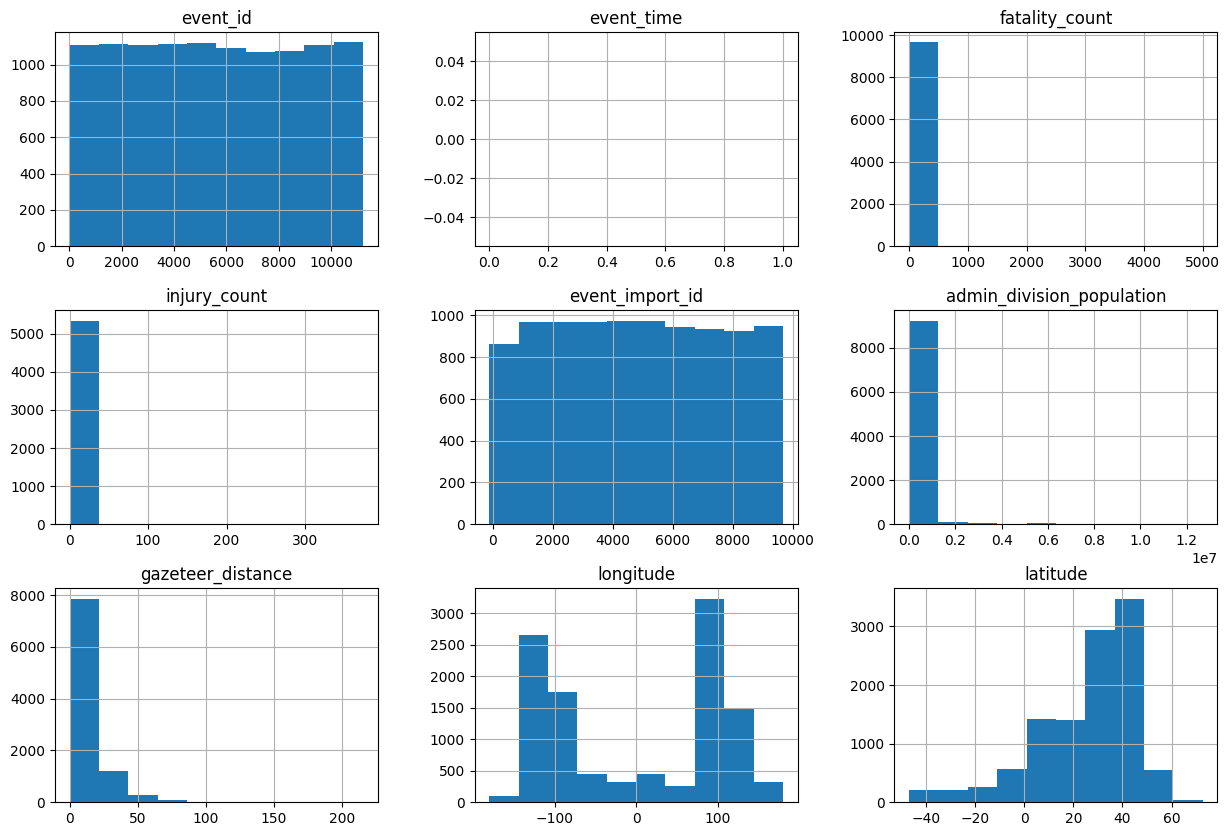

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns

# Descriptive statistics
print(df.describe())

# Histograms for numeric data
df.hist(figsize=(15, 10))
plt.show()

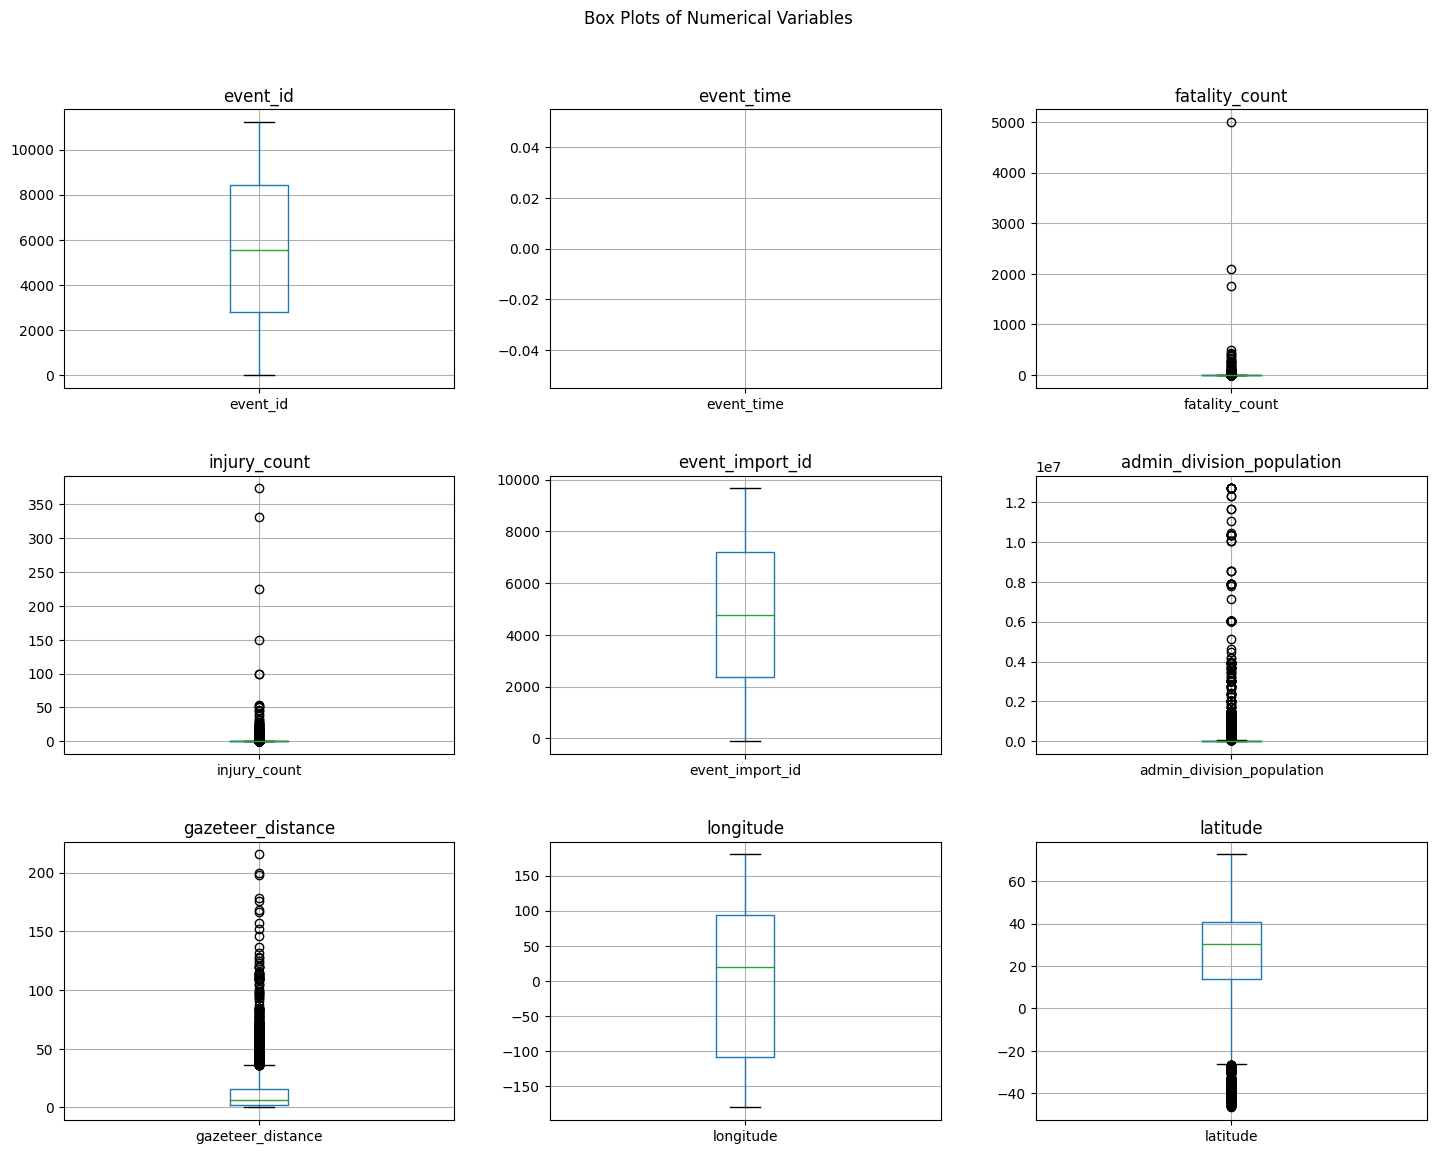

In [155]:
numerical_data = df.select_dtypes(include=['float64', 'int64'])

# Define the number of plots along the x and y axis
n_cols = 3  # Number of columns in the subplot grid
n_rows = (numerical_data.shape[1] + n_cols - 1) // n_cols  # Calculate number of rows needed

# Create a figure and axes with a dynamic size based on the number of subplots
plt.figure(figsize=(n_cols * 5, n_rows * 4))  # Adjust size dynamically

# Create subplots for each numerical column
for i, column in enumerate(numerical_data.columns):
    plt.subplot(n_rows, n_cols, i + 1)  # Position each subplot in the correct location
    df.boxplot(column=[column])
    plt.title(column)

plt.suptitle('Box Plots of Numerical Variables')
plt.tight_layout(pad=3.0)  # Add padding to ensure subplots don't overlap
plt.show()

In [156]:
storm_landslides = df[df['storm_name'].notna()]
# Summarizing the data
storm_summary = storm_landslides[['storm_name', 'landslide_size', 'fatality_count', 'injury_count']].groupby(['storm_name', 'landslide_size']).agg(
    total_events=pd.NamedAgg(column='storm_name', aggfunc='count'),
    total_fatalities=pd.NamedAgg(column='fatality_count', aggfunc='sum'),
    total_injuries=pd.NamedAgg(column='injury_count', aggfunc='sum')
).reset_index()
print(storm_summary)

                          storm_name landslide_size  total_events  \
0                                  0          small             1   
1                     1 hour of rain         medium             1   
2                     3 days of rain         medium             1   
3    5.6 miles southeast of Neah Bay          small             1   
4                             Agaton          large             7   
..                               ...            ...           ...   
257                            Wipha     very_large             1   
258                         and Rain         medium             1   
259                 cold front No. 7         medium             1   
260       ex-Tropical Cyclone Debbie          small             1   
261                        número 38         medium             1   

     total_fatalities  total_injuries  
0                 0.0             0.0  
1                 0.0             0.0  
2                 1.0             0.0  
3          

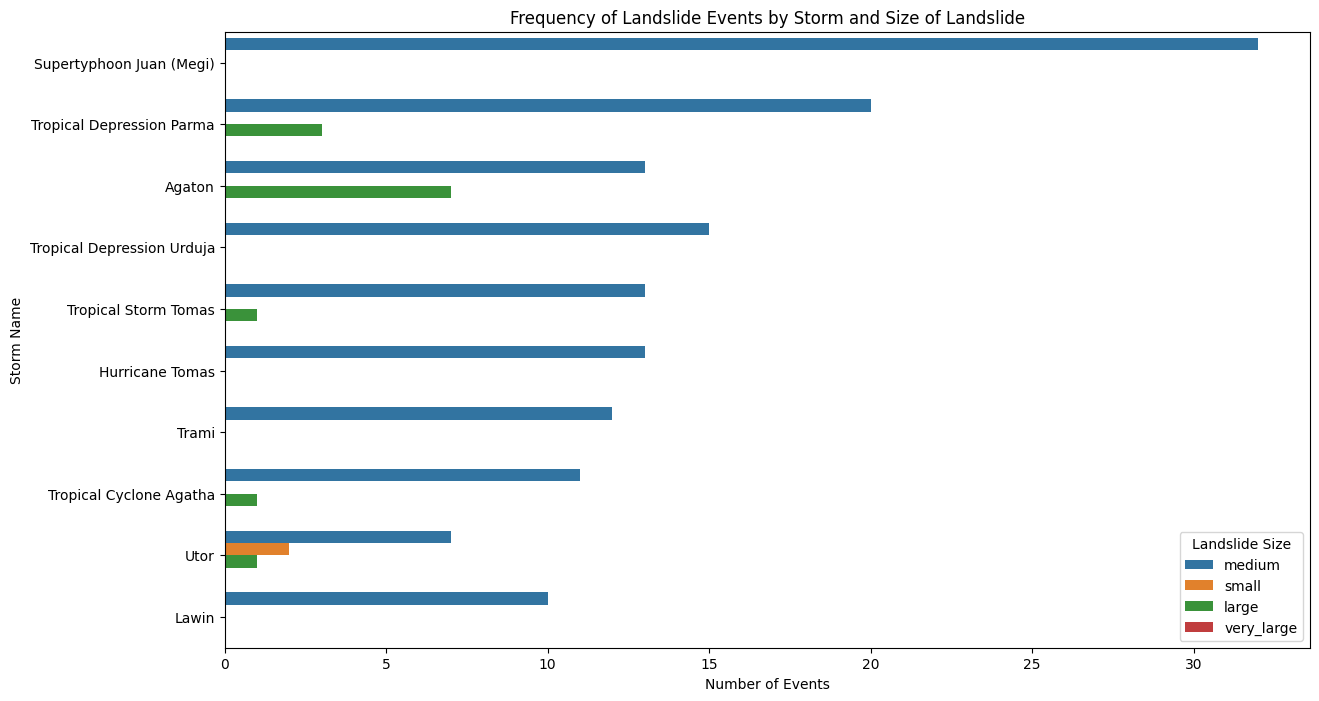

In [157]:
# Visualizing the relationship between storms and landslide size
plt.figure(figsize=(14, 8))
sns.countplot(data=storm_landslides, y='storm_name', hue='landslide_size', order=storm_landslides['storm_name'].value_counts().iloc[:10].index)
plt.title('Frequency of Landslide Events by Storm and Size of Landslide')
plt.xlabel('Number of Events')
plt.ylabel('Storm Name')
plt.legend(title='Landslide Size')
plt.show()

<ipython-input-158-5bc69855260c>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['event_date'] = pd.to_datetime(df['event_date'], errors='coerce')


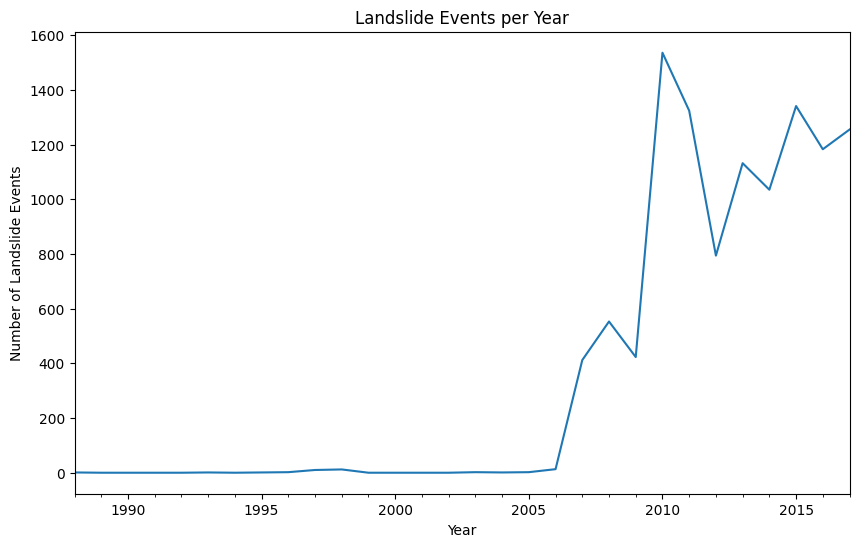

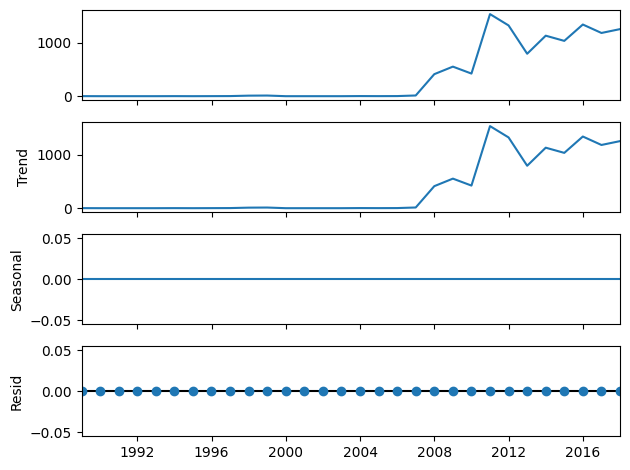

In [158]:
# Convert the 'event_date' column to datetime format
df['event_date'] = pd.to_datetime(df['event_date'], errors='coerce')
df['year'] = df['event_date'].dt.year
df['month'] = df['event_date'].dt.month
df['day'] = df['event_date'].dt.day
# Drop any NaT (not a time) values that couldn't be converted
df.dropna(subset=['event_date'], inplace=True)

# Set the 'event_date' as the index of the DataFrame
df.set_index('event_date', inplace=True)

# Drop rows with NaT values in the index if any
df = df[df.index.notna()]

# Resampling the data yearly and counting the number of events per year
yearly_data = df.resample('Y').size()

# Plotting the time series of landslide events
plt.figure(figsize=(10, 6))
yearly_data.plot(title='Landslide Events per Year')
plt.xlabel('Year')
plt.ylabel('Number of Landslide Events')
plt.show()

# Optional: Decompose the time series to observe trend, seasonal, and residual components
decomposition = seasonal_decompose(yearly_data, model='additive', period=1)  # Adjust period according to dataset
fig = decomposition.plot()
plt.show()

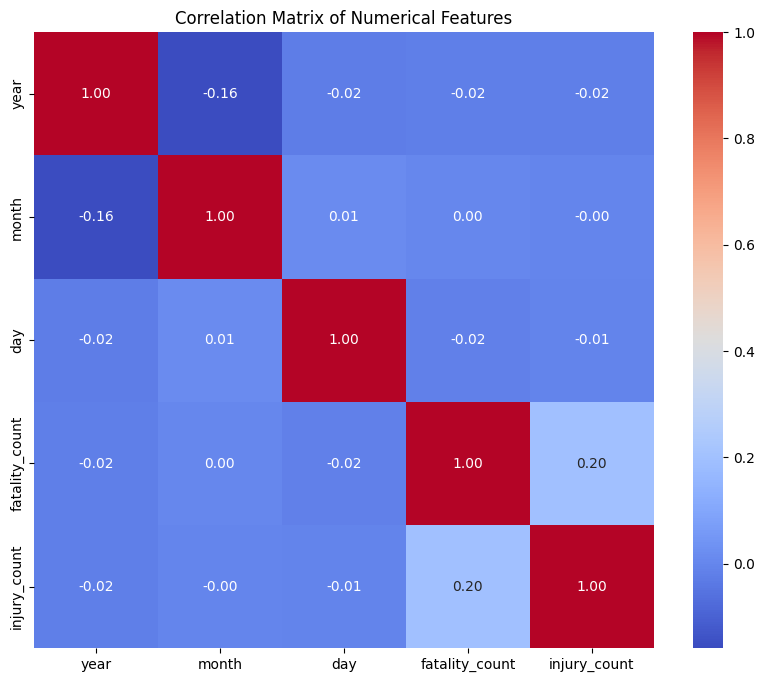

In [159]:
# Select numerical columns for correlation - example shown below
numerical_columns = ['year', 'month', 'day', 'fatality_count', 'injury_count']  # Add other numerical columns as needed
numerical_df = df[numerical_columns]

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

Observed Frequencies: [3431 2710 2626 2266]
Expected Frequencies (Uniform Distribution): [2758.25, 2758.25, 2758.25, 2758.25]
Chi-squared Test Statistic: 125.02781359884554
P-value: 6.374284648633936e-27


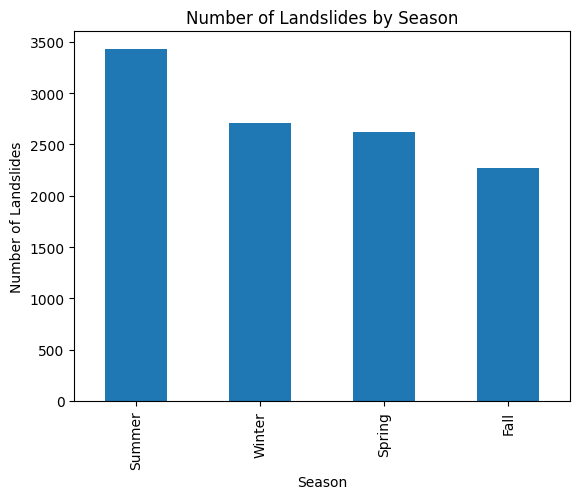

In [160]:
# Extract the month from the 'event_date' for seasonality - note that you can also map these to actual seasons
# Define the mapping of months to seasons (Northern Hemisphere)
month_to_season = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
}
df['season'] = df['month'].map(month_to_season)

# Count the number of landslides in each season
landslide_season_counts = df['season'].value_counts()

# Perform a Chi-squared test to see if the distribution across seasons is uniform
observed_frequencies = landslide_season_counts.values
expected_frequencies = [len(df) / 4] * 4  # Expect uniform distribution over 4 seasons
chi2, p_value = chi2_contingency([observed_frequencies, expected_frequencies])[0:2]

# Output the results
print(f"Observed Frequencies: {observed_frequencies}")
print(f"Expected Frequencies (Uniform Distribution): {expected_frequencies}")
print(f"Chi-squared Test Statistic: {chi2}")
print(f"P-value: {p_value}")

# Plot the distribution of landslides by season
landslide_season_counts.plot(kind='bar')
plt.title('Number of Landslides by Season')
plt.xlabel('Season')
plt.ylabel('Number of Landslides')
plt.show()

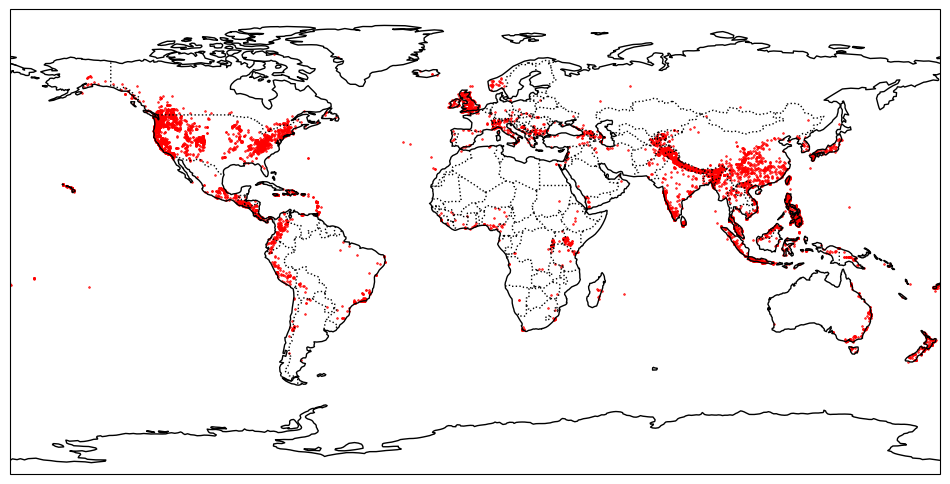

In [170]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))

# Plot the points in the world map
fig, ax = plt.subplots(figsize=(12,12),subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.set_extent([-180, 180, -90, 90])

gdf.plot(ax=ax, marker='*', color='red', markersize=1, alpha=0.7)

plt.show()